# Chronic Kidney Disease Prediction using Statistical Models
This project focuses on predicting the likelihood of chronic kidney disease in patients based on a comprehensive dataset containing 24 features. Chronic kidney disease is a serious medical condition, and early detection can significantly improve patient outcomes. The dataset comprises 400 data points, each labeled with the presence or absence of chronic kidney disease.
The primary goal of this project is to develop robust machine learning models for classifying patients as either at risk or not at risk of chronic kidney disease. Two classification algorithms, logistic regression and support vector machine (SVM), were employed to achieve accurate predictions.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import statsmodels.api as sm
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score #plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

## Loading Dataset

In [2]:
sheet_name = 'Complete_case'
df = pd.read_excel('01_datasets.xlsx',sheet_name=sheet_name)
df.head()

,age,blood pressure,specific gravity,albumin,Sugar,Pus Cell,Pus Cell clumps,Bacteria,Blood Glucose Random,Blood Urea,Serum Creatinine,Hemoglobin,Packed Cell Volume,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
0,48,80,1.020,1,0,normal,notpresent,notpresent,121,36.0,1.2,15.4,44,yes,yes,no,good,no,no,ckd
1,62,80,1.010,2,3,normal,notpresent,notpresent,423,53.0,1.8,9.6,31,no,yes,no,poor,no,yes,ckd
2,48,70,1.005,4,0,abnormal,present,notpresent,117,56.0,3.8,11.2,32,yes,no,no,poor,yes,yes,ckd
3,51,80,1.010,2,0,normal,notpresent,notpresent,106,26.0,1.4,11.6,35,no,no,no,good,no,no,ckd
4,68,70,1.010,0,0,normal,notpresent,notpresent,100,54.0,24.0,12.4,36,no,no,no,good,no,no,ckd


## Exploratory Data Analysis

### Class Distribution
Looking at the class distribution of datapoints with chronic kidney disease and without is important because if a class imbalance is found one needs to handle it before building a statistical model.

<Axes: xlabel='Class ', ylabel='count'>

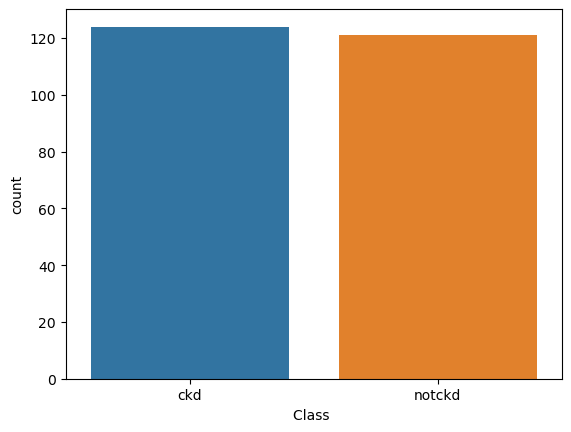

In [3]:
sns.countplot(data = df, x = 'Class ')

## Feature countplots
Looking at count plots of diffetent features with hue as the class to see the distribution and findout if particular feature has more importance in determining the chances of a person having chronic kidney disease.

### Count plot of Appetite with hue as Class

<Axes: xlabel='Appetite', ylabel='count'>

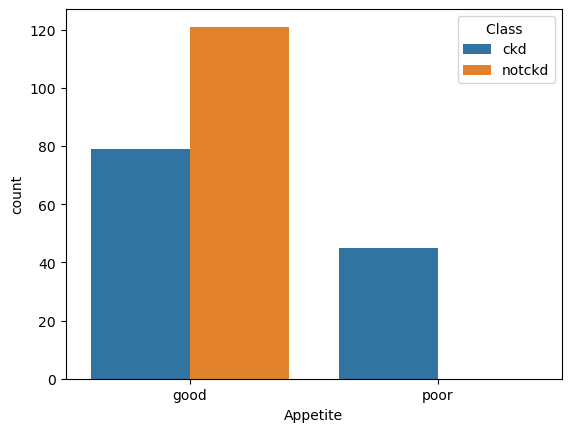

In [4]:
sns.countplot(data = df, x = 'Appetite', hue = 'Class ')

### Count plot of Diabetes Mellitus with hue as Class

<Axes: xlabel='Diabetes Mellitus', ylabel='count'>

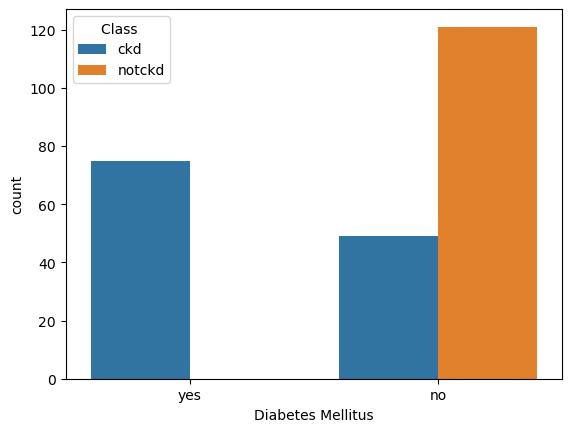

In [5]:
sns.countplot(data = df, x = 'Diabetes Mellitus', hue = 'Class ')

### Count plot of Specific Gravity with hue as Class

<Axes: xlabel='specific gravity', ylabel='count'>

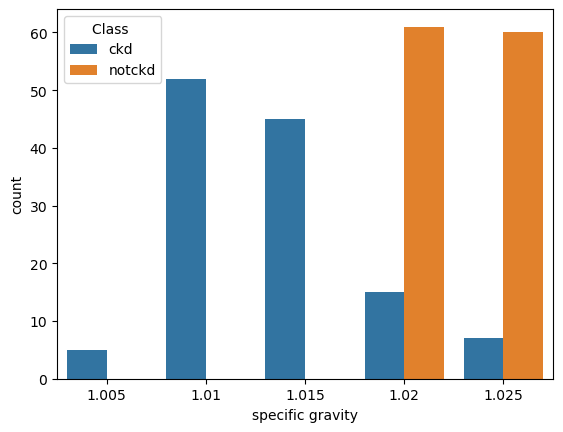

In [6]:
sns.countplot(data = df, x = 'specific gravity', hue = 'Class ')

### Checking data type of each Feature

In [7]:
feature_type = {}
for columns in df.columns:
    print(columns, ':', df[columns].dtype)
    feature_type[columns] = str(df[columns].dtype)

age : int64
blood pressure : int64
specific gravity : float64
albumin : int64
Sugar : int64
Pus Cell : object
Pus Cell clumps : object
Bacteria : object
Blood Glucose Random : int64
Blood Urea : float64
Serum Creatinine : float64
Hemoglobin : float64
Packed  Cell Volume : int64
Hypertension : object
Diabetes Mellitus : object
Coronary Artery Disease : object
Appetite : object
Pedal Edema : object
Anemia : object
Class  : object


## Pre Processing

### Converting categorical features to dummy variables
This is done to facilitate numerical representation which  ensuring compatibility with machine learning algorithms that require numeric input.

In [8]:
other_cat_features = ['specific gravity', 'albumin', 'Sugar', 'Red Blood Cells(nominal)']

In [9]:
#Dropping original categorical columns
for feature in feature_type:
    if (feature_type[feature] == 'object' and feature != 'Class ') or (feature in other_cat_features):
        dummies = pd.get_dummies(df[feature])
        for columns in dummies.columns:
            df[f'{feature}_{columns}'] = dummies[columns]
        
        df.drop(columns=[feature], inplace=True)

### Mapping class to Binary(1 and 0) 
Mapping the output class to binary as it is a binary classification problem.

In [10]:
df['Class '].value_counts()

Class 
ckd       124
notckd    121
Name: count, dtype: int64

In [11]:
df['Class '] = df['Class '].map(lambda x: 1 if x == 'ckd' else 0)
df['Class '].value_counts()

Class 
1    124
0    121
Name: count, dtype: int64

### Checking features if they have a clear seperation for CKD and non CKD patients
#### Scatter Plot of Packed Cell Volume with Hue as Class

<Axes: xlabel='Packed  Cell Volume', ylabel='Class '>

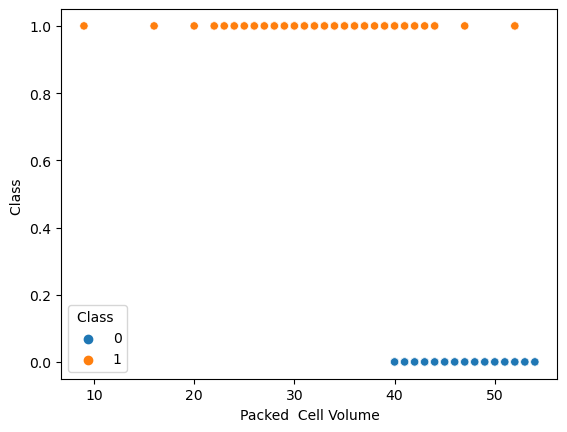

In [12]:
sns.scatterplot(data = df, x = 'Packed  Cell Volume', y = 'Class ', hue = 'Class ')

### Scatter Plot of Hemoglobin with Hue as Class 

<Axes: xlabel='Hemoglobin', ylabel='Class '>

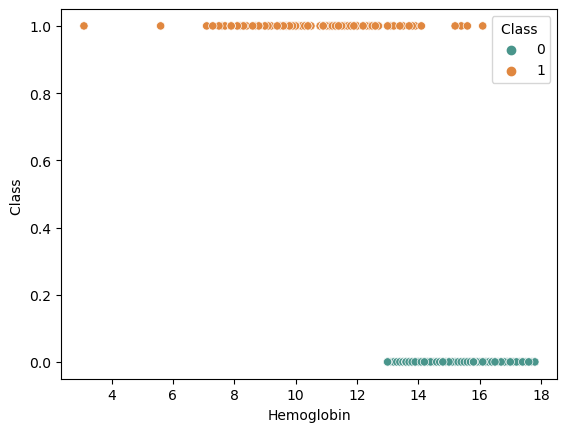

In [13]:
sns.scatterplot(data = df, x = 'Hemoglobin', y = 'Class ', hue = 'Class ', palette = ['#49958B', '#E0873F'])

## Scaling Continuous Data
Scaling numerical features to ensure consistent impact and better convergence in machine learning algorithms.

In [14]:
feature_scalar = {}
for feature in feature_type:
    if feature_type[feature] in ['int64', 'float64'] and feature not in other_cat_features:
        scalar = StandardScaler().fit(df[feature].values.reshape(-1,1))
        df.loc[:,feature] = scalar.transform(df[feature].values.reshape(-1,1))

        feature_scalar[feature] = scalar
feature_scalar

{'age': StandardScaler(),
 'blood pressure': StandardScaler(),
 'Blood Glucose Random': StandardScaler(),
 'Blood Urea': StandardScaler(),
 'Serum Creatinine': StandardScaler(),
 'Hemoglobin': StandardScaler(),
 'Packed  Cell Volume': StandardScaler()}

In [15]:
df

,age,blood pressure,Blood Glucose Random,Blood Urea,Serum Creatinine,Hemoglobin,Packed Cell Volume,Class,specific gravity_1.005,specific gravity_1.01,...,Diabetes Mellitus_no,Diabetes Mellitus_yes,Coronary Artery Disease_no,Coronary Artery Disease_yes,Appetite_good,Appetite_poor,Pedal Edema_no,Pedal Edema_yes,Anemia_no,Anemia_yes
0,-0.237616,0.381919,-0.303475,-0.401425,-0.383738,0.887954,0.503524,1,False,False,...,False,True,True,False,True,False,True,False,True,False
1,0.641589,0.381919,3.513299,-0.014448,-0.200054,-1.196949,-0.988313,1,False,True,...,False,True,True,False,False,True,True,False,False,True
2,-0.237616,-0.484471,-0.354028,0.053842,0.412228,-0.621803,-0.873556,1,True,False,...,True,False,True,False,False,True,False,True,False,True
3,-0.049215,0.381919,-0.493049,-0.629059,-0.322510,-0.478016,-0.529286,1,False,True,...,True,False,True,False,True,False,True,False,True,False
4,1.018391,-0.484471,-0.568879,0.008316,6.596271,-0.190444,-0.414529,1,False,True,...,True,False,True,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,0.201986,0.381919,-0.063346,-0.105501,-0.598037,0.995794,0.847794,0,False,False,...,True,False,True,False,True,False,True,False,True,False
241,-0.614418,-0.484471,-0.884837,-0.515242,-0.383738,1.283367,1.651091,0,False,False,...,True,False,True,False,True,False,True,False,True,False
242,-2.498428,0.381919,-0.568879,-0.629059,-0.567423,1.031741,1.077308,0,False,False,...,True,False,True,False,True,False,True,False,True,False
243,-2.184426,-1.350861,-0.391943,-0.082738,-0.444966,0.456595,1.306821,0,False,False,...,True,False,True,False,True,False,True,False,True,False


## Splitting the dataset into test train split
This is a necessary step as splitting the dataset into training and testing sets helps assess the model's generalization performance. The training set is used to train the model, and the testing set evaluates how well the model performs on unseen data, providing insights into its real-world applicability and potential overfitting.

In [16]:
property_variable = 'Class '
X_all = df[[x for x in df.columns if x != property_variable]].values
Y_all = df[property_variable].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size = 0.2)

# Generating Models
## Logistic Regression
### Cross Validation
Cross-validation is crucial for obtaining a more robust estimate of the model's performance. It involves splitting the dataset into multiple folds, training the model on different subsets, and evaluating its performance. This helps ensure that the model's performance is consistent across various data partitions and reduces the risk of overfitting or underfitting to a specific training set.

In [17]:
from sklearn.model_selection import cross_val_score
cv = ShuffleSplit(n_splits=10, test_size=0.15)
scores = cross_val_score(LogisticRegression(max_iter=500, fit_intercept=False, C=1e9), X_train, Y_train.reshape(-1), cv = cv)

In [18]:
lr_df = pd.DataFrame({'iteration' : [f'iterration_{i}' for i in range(1, 11)], 'acurracy_score' : scores})
print(f"Mean: {lr_df['acurracy_score'].mean()}")
print(f"Std: {lr_df['acurracy_score'].std()}")

Mean: 0.9833333333333334
Std: 0.01756820922315766


### Final Logistic Regression Model

In [19]:
log_reg = LogisticRegression(max_iter=500, fit_intercept=False, C=1e9).fit(X_train, Y_train.reshape(-1))

In [20]:
y_pred = log_reg.predict(X_test)

Confusion Matrix : 
 [[28  0]
 [ 2 19]]


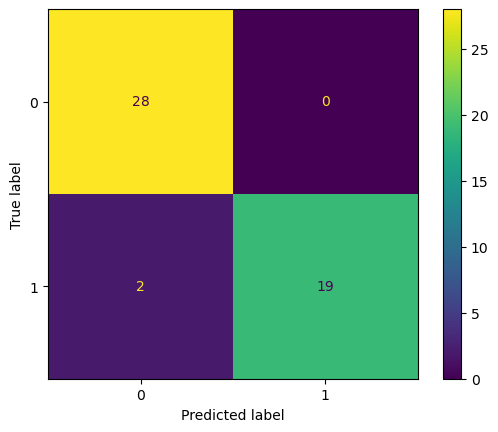

In [21]:
cm = confusion_matrix(Y_test, y_pred) 
print ("Confusion Matrix : \n", cm) 

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Support Vector Machine
### Cross Validation and Hypertuning to find most Optimal Parameters
SVM models have hyperparameters C, kernel type and gamma that significantly impact their performance. Tuning these hyperparameters involves searching for the optimal combination that maximizes the model's accuracy, precision, or other relevant metrics. Hyperparameter tuning helps fine-tune the model, improving its ability to generalize to unseen data and enhancing overall predictive performance.

In [22]:
param_grid = [
    {'C' : [0.5,1,10,100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
]

cv = ShuffleSplit(n_splits=20, test_size=0.15)

In [23]:
Y_train.reshape(-1).shape

(196,)

In [24]:
optimal_params = GridSearchCV(SVC(), param_grid, cv = cv, verbose =1)
print(optimal_params.fit(X_train,Y_train.reshape(-1)))

Fitting 20 folds for each of 96 candidates, totalling 1920 fits
GridSearchCV(cv=ShuffleSplit(n_splits=20, random_state=None, test_size=0.15, train_size=None),
             estimator=SVC(),
             param_grid=[{'C': [0.5, 1, 10, 100],
                          'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}],
             verbose=1)


In [25]:
parameters_HT_df = pd.DataFrame(optimal_params.cv_results_)[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by = 'rank_test_score')
parameters_HT_df

,params,mean_test_score,std_test_score,rank_test_score
34,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.983333,0.019720,1
58,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",0.983333,0.019720,1
26,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.983333,0.019720,1
82,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}",0.983333,0.019720,1
74,"{'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}",0.983333,0.019720,1
...,...,...,...,...
69,"{'C': 10, 'gamma': 0.0001, 'kernel': 'poly'}",0.503333,0.051532,82
45,"{'C': 1, 'gamma': 0.0001, 'kernel': 'poly'}",0.503333,0.051532,82
46,"{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.503333,0.051532,82
19,"{'C': 0.5, 'gamma': 0.001, 'kernel': 'sigmoid'}",0.503333,0.051532,82


In [26]:
best_params = optimal_params.best_params_
print(best_params)

{'C': 0.5, 'gamma': 0.1, 'kernel': 'rbf'}


### Training SVC on Optimal Parameters

In [27]:
svc = SVC(C = best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel']).fit(X_train, Y_train.reshape(-1))

In [28]:
y_pred = svc.predict(X_test)

Confusion Matrix : 
 [[28  0]
 [ 0 21]]


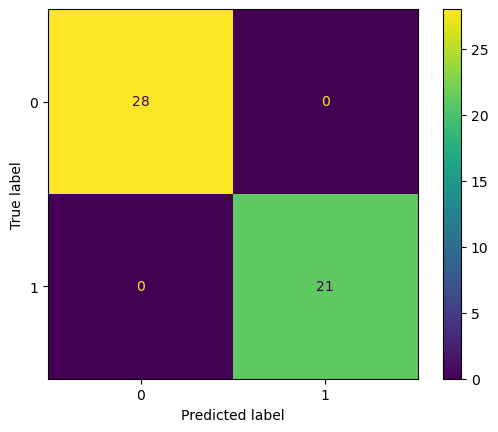

In [29]:
cm = confusion_matrix(Y_test, y_pred) 
print ("Confusion Matrix : \n", cm) 

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Generating Feature Impertance

In [30]:
print(log_reg.coef_.shape)
feature_name = [x for x in df.columns if x != property_variable]
feature_import = {'Features':feature_name, 'Coefficients':log_reg.coef_.reshape(-1)}
feature_import = pd.DataFrame(feature_import)

(1, 41)


In [31]:
feature_import['importance_exp'] = feature_import['Coefficients'].map(lambda x : np.exp(abs(x)))
feature_import['importance'] = feature_import['Coefficients'].map(lambda x : (abs(x)))

In [32]:
feature_import.sort_values(by='importance', ascending=False, inplace=True)

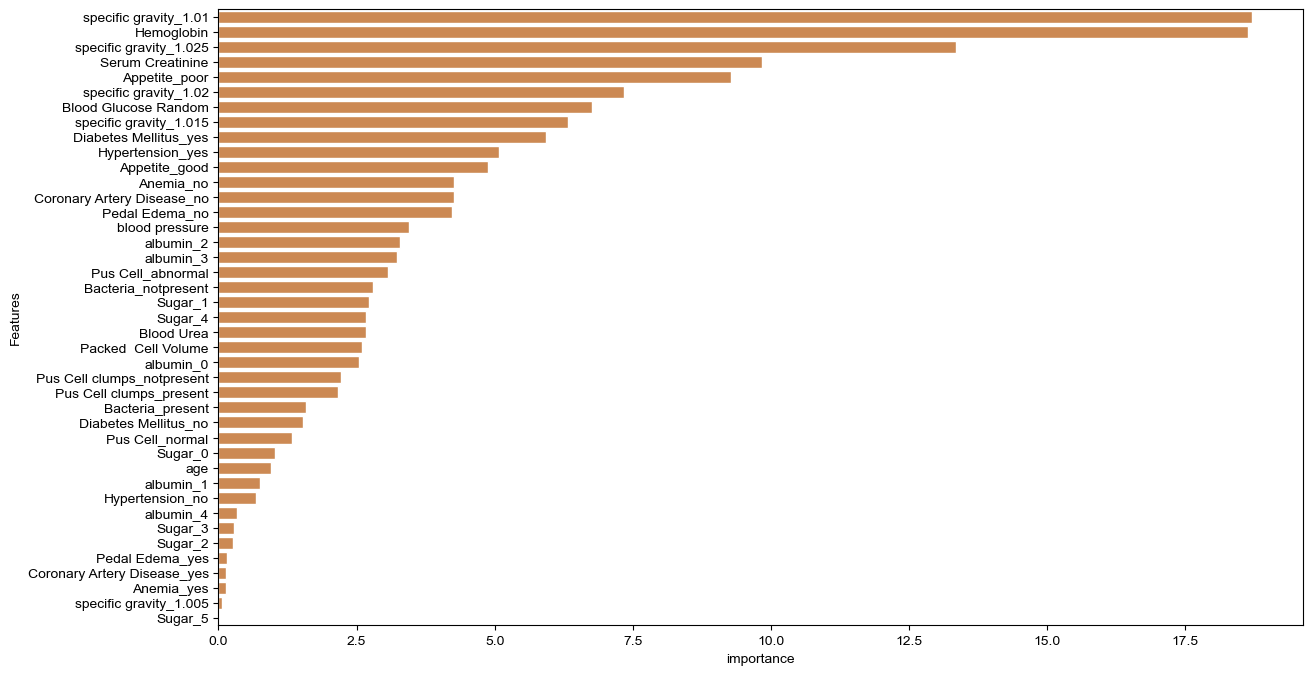

In [33]:
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot()
sns.set(font_scale=0.8)
sns.barplot(data = feature_import, x='importance', y='Features', orient='hor', color='#E0873F', ax=ax)
#ax.tick_params(axis='both', labelcolor='white')
#ax.xaxis.label.set_color('white')
#ax.yaxis.label.set_color('white')
plt.savefig(f'Feature_Importance.png', dpi = 300, transparent = True)

<Axes: xlabel='importance_exp', ylabel='Features'>

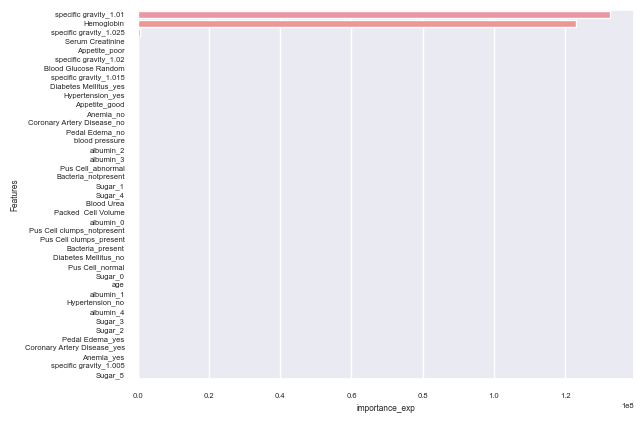

In [34]:
sns.set(font_scale=0.5)
sns.barplot(data = feature_import, x='importance_exp', y='Features', orient='hor')

In [35]:
feature_import

,Features,Coefficients,importance_exp,importance
8,specific gravity_1.01,18.703495,1.326859e+08,18.703495
5,Hemoglobin,-18.628833,1.231401e+08,18.628833
11,specific gravity_1.025,-13.357606,6.326076e+05,13.357606
4,Serum Creatinine,9.840531,1.877968e+04,9.840531
36,Appetite_poor,9.269048,1.060465e+04,9.269048
10,specific gravity_1.02,-7.337363,1.536655e+03,7.337363
2,Blood Glucose Random,6.762970,8.652081e+02,6.762970
9,specific gravity_1.015,6.324337,5.579879e+02,6.324337
32,Diabetes Mellitus_yes,5.923300,3.736427e+02,5.923300
30,Hypertension_yes,5.080315,1.608248e+02,5.080315


## Conclusion
In conclusion, the analysis of various models for data-driven chronic kidney disease diagnosis has yielded promising results. However, it's important to note that further research and development are needed to enhance the efficacy and applicability of these models in real-world healthcare scenarios. This project highlights the immense potential of data-driven solutions in improving healthcare outcomes and paving the way for more accurate and efficient diagnoses.